In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import  StandardScaler, OrdinalEncoder
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (accuracy_score,
                             roc_auc_score, 
                             roc_curve,
                             precision_score, 
                             recall_score, 
                             f1_score, 
                             classification_report, 
                             confusion_matrix)
from lightgbm import LGBMClassifier

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

CHIA TAP DU LIEU 
train : val : test = 6:2:2

In [2]:
# 1. Đọc dữ liệu
df_train = pd.read_parquet('train.parquet')
df_valid = pd.read_parquet('validation.parquet')
df_test  = pd.read_parquet('test.parquet')

In [3]:



# 2. Cột loại bỏ
cols_to_drop = [
    'fraud',
    'ngay_hhluc_khang', 'ngay_hhluc_vitri_ddo', 'ngay_hhluc_diemdo', 'ngay_hhluc',
    'id_bcs', 'ngay_kdinh', 'loai_chiso', 'ngay_hluc_diem_do', 'ngay_hluc_vitri_ddo',
    'thang_csuat_ddo', 'ngay_hluc_khang', 'gia_tri', 'loai_giatri', 'kimua_cspk',
    'id_ddo', 'ma_dviqly', 'so_cot', 'so_hop', 'ma_dvictren', 'ky', 'thang', 'nam',
    'sluong_ttiep', 'sluong_trphu', 'thd_le', 'ma_cnang_chiso', 'ngay_bdong',
    'id_khang', 'so_pha', 'ngay_tao_chiso', 'nguoi_tao_chiso', 'ngay_sua_chiso',
    'nguoi_sua_chiso', 'ngay_hluc'
]

# 3. Tách X, y
X_train = df_train.drop(columns=cols_to_drop)
y_train = df_train['fraud']
X_valid = df_valid.drop(columns=cols_to_drop)
y_valid = df_valid['fraud']
X_test = df_test.drop(columns=cols_to_drop)
y_test = df_test['fraud']

# XGB

In [4]:
SEED = 42   
xgb_params = {
    # 'enable_categorical': True,
    'tree_method':        'hist',
    'random_state':       SEED,
    'learning_rate':      0.08501257473292347,
    'lambda':             8.879624125465703,
    'alpha':              0.6779926606782505,
    'max_depth':          6,
    'subsample':          0.6012681388711075,
    'colsample_bytree':   0.8437772277074493,
    'colsample_bylevel':  0.5476090898823716,
    'colsample_bynode':   0.9928601203635129,
    'scale_pos_weight':   3.29440313334688
}

lgb_params = {
    'objective':        'binary',
    'verbosity':        -1,
    'n_iter':           200,
    'boosting_type':    'gbdt',
    'random_state':     SEED,
    'lambda_l1':        0.08758718919397321,
    'lambda_l2':        0.0039689175176025465,
    'learning_rate':    0.03231007103195577,
    'max_depth':        4,
    'num_leaves':       103,
    'colsample_bytree': 0.8329551585827726,
    'colsample_bynode': 0.4025961355653304,
    'bagging_fraction': 0.7738954452473223,
    'bagging_freq':     4,
    'min_data_in_leaf': 85,
    'scale_pos_weight': 2.7984184778875543,
    # 'device': 'gpu'
}

cb_params = {
    'loss_function':     'Logloss',
    'iterations':        250,
    'verbose':           False,
    'random_state':      SEED,
    'max_depth':         7,
    'learning_rate':     0.06936242010150652,
    'scale_pos_weight':  2.6149345838209532,
    'l2_leaf_reg':       6.216113851699493,
    'subsample':         0.6249261779711819,
    'min_data_in_leaf':  24,
    # 'cat_features':      cat_cols,
}

# Tạo pipeline với resampling
#oversampler = RandomOverSampler(sampling_strategy=0.03, random_state=SEED)
#undersampler = RandomUnderSampler(sampling_strategy=0.03, random_state=SEED)

# # Tạo pipeline với oversampling và undersampling
# augmentation = Pipeline([
#     ('oversample', oversampler),
#     ('undersample', undersampler)
# ])

# # Áp dụng resampling vào tập huấn luyện
# X_train_resampled, y_train_resampled = augmentation.fit_resample(X_train, y_train)

# # In ra số lượng nhãn 0 và 1 sau khi resampling
# print("After resampling:")
# print("Count of label 0:", np.sum(y_train_resampled == 0))
# print("Count of label 1:", np.sum(y_train_resampled == 1))

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Tạo custom transformer để thực hiện oversampling và undersampling
class ResampleTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, oversampler, undersampler):
        self.oversampler = oversampler
        self.undersampler = undersampler

    def fit(self, X, y):
        # Không cần fit gì ở đây, chỉ cần trả về chính X, y
        return self

    def transform(self, X, y=None):
        # Áp dụng oversampling rồi đến undersampling nếu y không phải None
        if y is not None:
            X_res, y_res = self.oversampler.fit_resample(X, y)
            X_res, y_res = self.undersampler.fit_resample(X_res, y_res)
            return X_res, y_res
        return X  # Nếu y là None, chỉ trả về X


In [11]:
print(np.bincount(y_train))

[13138492   168491]


In [12]:
SEED = 42
oversampler = RandomOverSampler(sampling_strategy=0.03, random_state=SEED)
undersampler = RandomUnderSampler(sampling_strategy=0.03, random_state=SEED)
resample = ResampleTransformer(oversampler, undersampler)


[13138466   394154]


In [22]:

X_train_res, y_train_res = resample.transform(X_train, y_train)

In [23]:
import xgboost as xgb

# Tạo DMatrix
dtrain = xgb.DMatrix(X_train_res, label=y_train_res)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

# Sao chép tham số gốc để giữ nguyên
params = xgb_params.copy()
params.update({
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'error'],
    'verbosity': 1
    # Nếu bạn cần scale_pos_weight thì thêm tại đây
    # 'scale_pos_weight': 77.98
})

# Train model
evals_result = {}
booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dvalid, 'valid')],
    early_stopping_rounds=30,
    evals_result=evals_result,
    verbose_eval=10
)


[0]	train-logloss:0.10709	train-error:0.02913	valid-logloss:0.06310	valid-error:0.01266
[10]	train-logloss:0.06247	train-error:0.02563	valid-logloss:0.04039	valid-error:0.01129
[20]	train-logloss:0.04922	train-error:0.02148	valid-logloss:0.03279	valid-error:0.01042
[30]	train-logloss:0.04273	train-error:0.01988	valid-logloss:0.02897	valid-error:0.01058
[40]	train-logloss:0.03849	train-error:0.01858	valid-logloss:0.02644	valid-error:0.01058
[47]	train-logloss:0.03694	train-error:0.01791	valid-logloss:0.02550	valid-error:0.01123


In [26]:
print(evals_result.keys())                      # training, validation_0...    # logloss, error...


dict_keys(['train', 'valid'])


In [28]:

# Loss
train_loss = evals_result['train']['logloss']
val_loss   = evals_result['valid']['logloss']

# Accuracy = 1 - binary_error
train_acc = [1 - e for e in evals_result['train']['error']]
val_acc   = [1 - e for e in evals_result['valid']['error']]

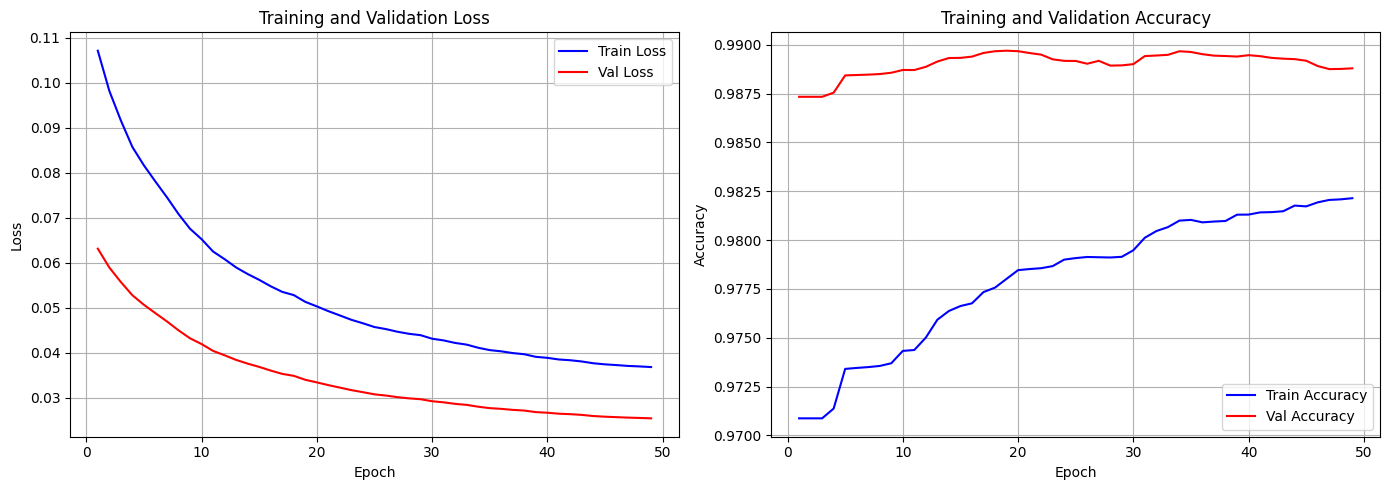

In [29]:
import matplotlib.pyplot as plt

# Epochs
epochs = range(1, len(train_loss) + 1)

# Vẽ
plt.figure(figsize=(14, 5))

# Loss subplot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Train Loss')
plt.plot(epochs, val_loss, 'r', label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy subplot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b', label='Train Accuracy')
plt.plot(epochs, val_acc, 'r', label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [40]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

# Dự đoán xác suất
y_prob = booster.predict(xgb.DMatrix(X_test))

# Dự đoán nhãn
y_pred = (y_prob >= 0.3).astype(int)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Precision
precision = precision_score(y_test, y_pred, zero_division=0)

# Recall
recall = recall_score(y_test, y_pred, zero_division=0)

# F1-Score
f1 = f1_score(y_test, y_pred, zero_division=0)

# ROC AUC
roc_auc = roc_auc_score(y_test, y_prob)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Classification Report
report = classification_report(y_test, y_pred, digits=4)

# In kết quả
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)


Accuracy:  0.9861
Precision: 0.4730
Recall:    0.8721
F1-Score:  0.6133
ROC AUC:   0.9940
Confusion Matrix:
[[4324921   54577]
 [   7181   48982]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9983    0.9875    0.9929   4379498
           1     0.4730    0.8721    0.6133     56163

    accuracy                         0.9861   4435661
   macro avg     0.7357    0.9298    0.8031   4435661
weighted avg     0.9917    0.9861    0.9881   4435661



In [6]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb
SEED = 42
X = pd.concat([X_train, X_valid], axis=0)
y=pd.concat([y_train, y_valid], axis=0)
# Sử dụng StratifiedKFold để đảm bảo tỷ lệ lớp
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=SEED)

# Tính toán scale_pos_weight để xử lý mất cân bằng dữ liệu
class_imbalance_ratio = sum(y == 0) / sum(y == 1)
scale_pos_weight = class_imbalance_ratio  # Tỷ lệ giữa lớp âm và lớp dương

# Khởi tạo mô hình CatBoost với các siêu tham số tốt nhất
model = xgb.XGBClassifier(**xgb_params)

# Khởi tạo các phương pháp resampling
oversampler = RandomOverSampler(sampling_strategy=0.03, random_state=SEED)
undersampler = RandomUnderSampler(sampling_strategy=0.03, random_state=SEED)

# Tạo pipeline hoàn chỉnh sử dụng custom transformer
full_pipeline = Pipeline([
    ('resample', ResampleTransformer(oversampler, undersampler)),
    ('model', model)
])
# Định nghĩa hàm custom metric
def custom_metric(estimator, X, y_true):
    y_hat = estimator.predict_proba(X)[:, 1]
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)
    
    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return partial_auc

# Đánh giá mô hình bằng cross-validation với custom transformer
print("Performing cross-validation with Augmentation...")
cross_val_results = cross_validate(
    full_pipeline,
    X,
    y,
    cv=skf,
    scoring=custom_metric,
    verbose=1
)

# In ra kết quả cross-validation
print(f'Cross-validation pAUC scores: {cross_val_results["test_score"]}')
print(f'Mean pAUC: {cross_val_results["test_score"].mean():.4f}, Std: {cross_val_results["test_score"].std():.4f}')

# Huấn luyện mô hình cuối cùng trên toàn bộ dữ liệu
print("Training final model on the entire combined dataset...")
full_pipeline.fit(X, y)

Performing cross-validation with Augmentation...
Cross-validation pAUC scores: [0.19744979 0.19738535]
Mean pAUC: 0.1974, Std: 0.0000
Training final model on the entire combined dataset...


Pipeline(steps=[('resample',
                 ResampleTransformer(oversampler=RandomOverSampler(random_state=42,
                                                                   sampling_strategy=0.03),
                                     undersampler=RandomUnderSampler(random_state=42,
                                                                     sampling_strategy=0.03))),
                ('model',
                 XGBClassifier(alpha=0.6779926606782505, base_score=None,
                               booster=None, callbacks=None,
                               colsample_bylevel=0.5476090898823716,
                               colsample_bynode=0.9928601203...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               lambda=8.879624125465703,
                               learning_rate=0.08501257473292347, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=6,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None, ...))])

In [39]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

y_pred = full_pipeline.predict(X_test)
y_pred_proba = full_pipeline.predict_proba(X_test)[:, 1]  # Xác suất của lớp dương

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# In kết quả đánh giá
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.9885
Precision: 0.5302
Recall: 0.8409
F1-Score: 0.6503
ROC AUC: 0.9953
Confusion Matrix:
[[4337644   41854]
 [   8936   47227]]


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   4379497
           1       0.52      0.82      0.64     56164

    accuracy                           0.99   4435661
   macro avg       0.76      0.91      0.82   4435661
weighted avg       0.99      0.99      0.99   4435661



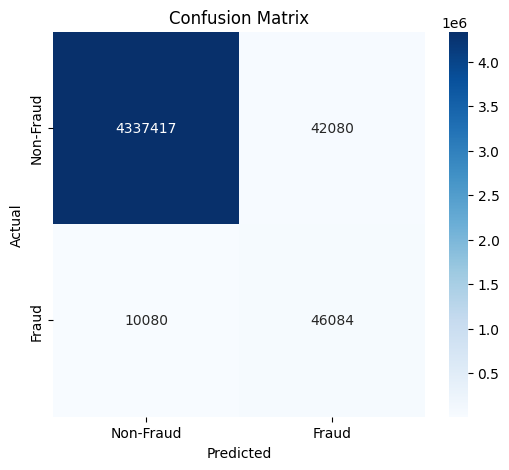

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Dự đoán trên tập test
X_test = X_test
y_pred = full_pipeline.predict(X_test)

# Đánh giá mô hình với classification report và confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Vẽ confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [7]:
# Định nghĩa độ đo tùy chỉnh (Partial AUC)
def custom_metric(y_true, y_pred_proba):
    min_tpr = 0.80  # Ngưỡng TPR tối thiểu
    max_fpr = abs(1 - min_tpr)  # Ngưỡng FPR tối đa
    
    v_gt = abs(y_true - 1)  # Chuyển đổi y_true thành lớp tích cực (1) và lớp tiêu cực (0)
    v_pred = np.array([1.0 - x for x in y_pred_proba])  # Chuyển đổi xác suất dự đoán thành lớp tiêu cực
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)  # Tính AUC của phần có FPR giới hạn
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)  # Điều chỉnh AUC

    return partial_auc

# Lấy xác suất dự đoán của lớp tích cực (Fraud)
y_pred_proba = full_pipeline.predict_proba(X_test)[:, 1]  # Dự đoán xác suất lớp tích cực (Fraud)

# Tính độ đo tùy chỉnh trên tập test
custom_auc_score = custom_metric(y_test, y_pred_proba)

# In kết quả độ đo tùy chỉnh
print(f'Custom pAUC Score: {custom_auc_score}')
print(f'AUC Score: {roc_auc_score(y_test, y_pred_proba)}')

Custom pAUC Score: 0.19736805907054208
AUC Score: 0.9953279245692729


In [ ]:
Features = [col for col in data.columns if col not in cols_to_drop]
print(Features)

['id_chiso', 'ma_ddo', 'bcs_chiso', 'hs_nhan', 'so_cto_chiso', 'chiso_cu', 'chiso_moi', 'san_luong', 'ma_ttcto', 'ngay_dky', 'ngay_cky', 'sluong_1', 'sluong_2', 'sluong_3', 'ma_tram', 'ma_cto', 'so_cto_hso_cto', 'ma_bdong', 'dong_dien', 'dien_ap', 'vh_cong', 'ma_cloai', 'ten_khang', 'ma_khang', 'dia_chi', 'csuat', 'so_cto_csuat_ddo']


C:\Users\HOME\AppData\Local\Temp\ipykernel_2364\514820566.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s.set_xticklabels(s.get_xticklabels(),rotation=90)


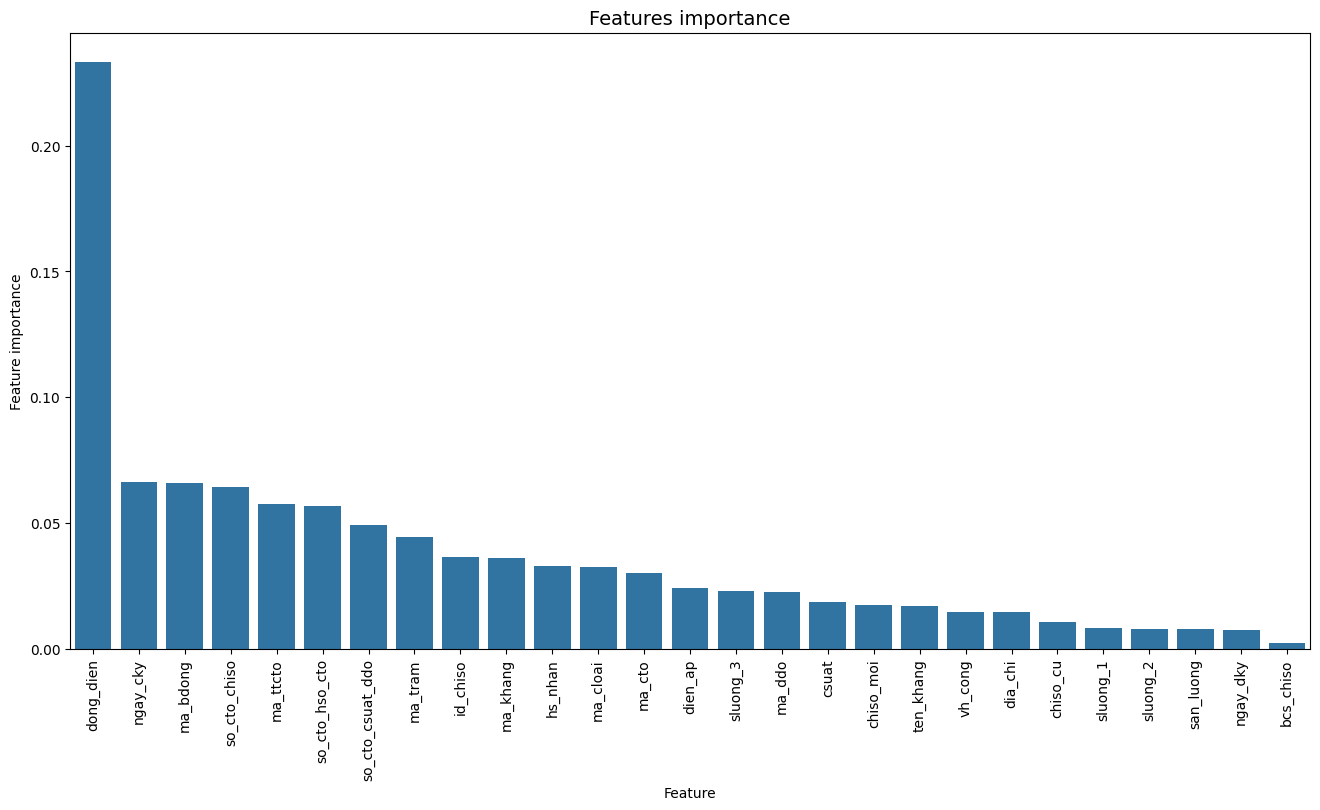

In [18]:
tmp = pd.DataFrame({'Feature': Features, 'Feature importance': model.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (16,8))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

In [19]:
# Đếm số lượng mẫu mỗi lớp trong tập train, val và test
def count_class_distribution(y, name=""):
    fraud_count = (y == 1).sum()
    nonfraud_count = (y == 0).sum()
    print(f"{name} set:")
    print(f"  Fraud     (1): {fraud_count}")
    print(f"  Non-Fraud (0): {nonfraud_count}")
    print("-" * 40)

count_class_distribution(y_train, "TRAIN")
count_class_distribution(y_val, "VALIDATION")
count_class_distribution(y_test, "TEST")


TRAIN set:
  Fraud     (1): 168491
  Non-Fraud (0): 13138492
----------------------------------------
VALIDATION set:
  Fraud     (1): 56163
  Non-Fraud (0): 4379498
----------------------------------------
TEST set:
  Fraud     (1): 56164
  Non-Fraud (0): 4379497
----------------------------------------


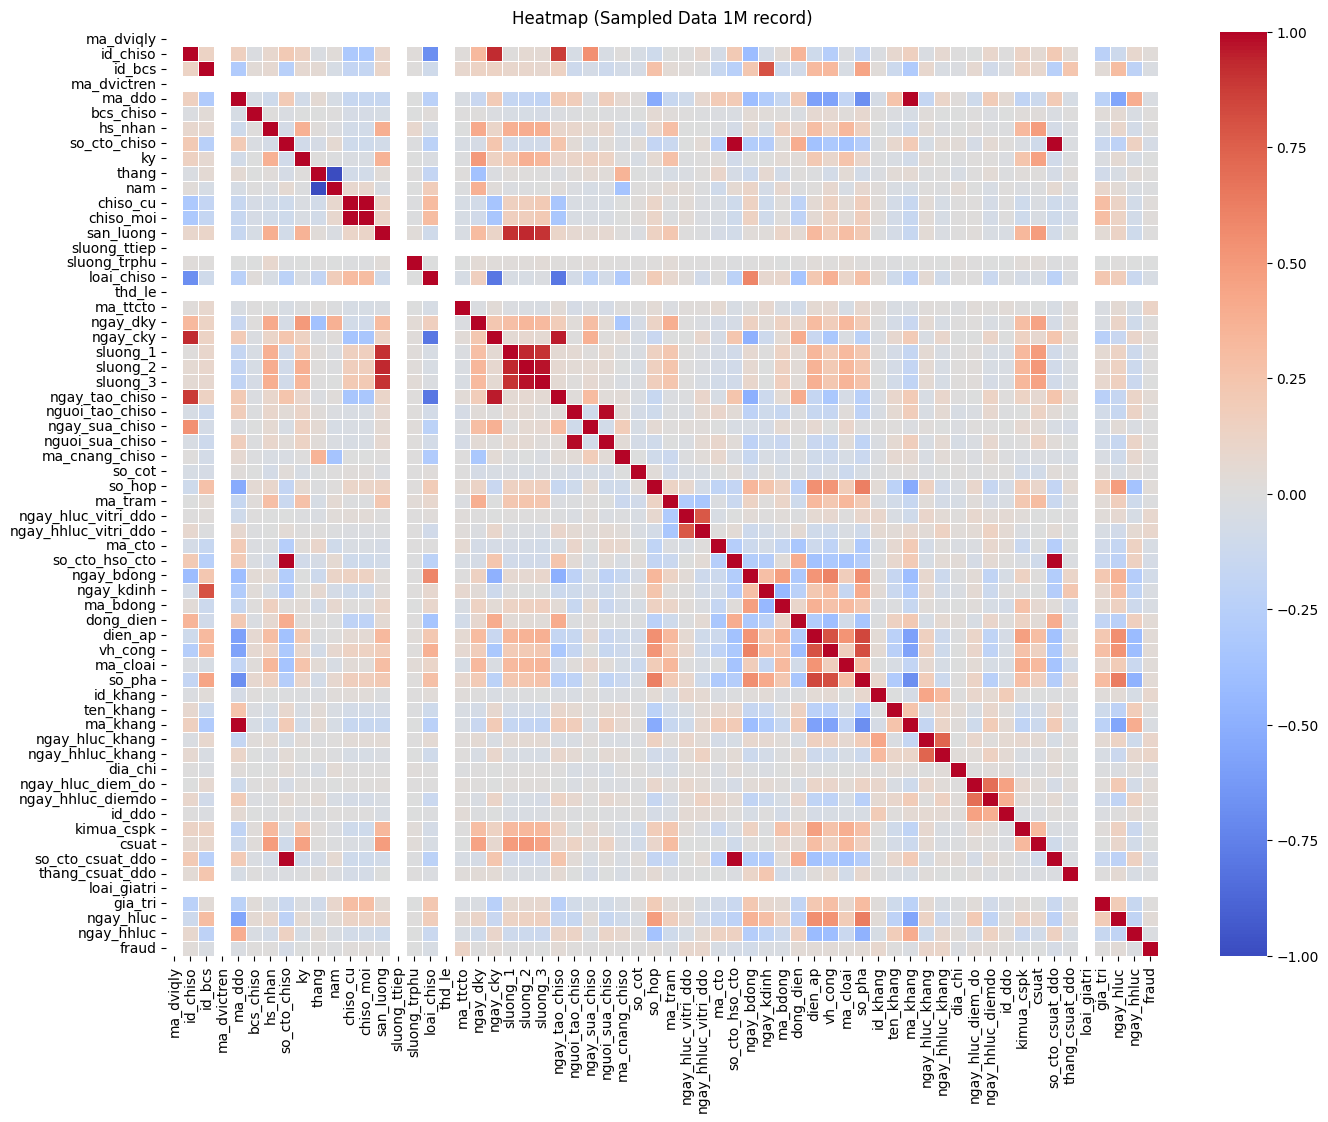

In [20]:
import matplotlib.pyplot as plt
# Lấy mẫu 100,000 dòng
data_sample = data.sample(n=100000, random_state=42)

# Tính ma trận tương quan trên mẫu
corr_matrix = data_sample.corr(numeric_only=True)

# Vẽ heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Heatmap (Sampled Data 1M record)")
plt.show()


In [21]:
# Tính tỉ lệ lớp Fraud trong tập train và test
train_ratio = y_train.mean()
test_ratio = y_test.mean()
val_ratio = y_val.mean()

print(f"Tỉ lệ Fraud trong tập TRAIN: {train_ratio:.4f} ({train_ratio*100:.2f}%)")
print(f"Tỉ lệ Fraud trong tập TEST:  {test_ratio:.4f} ({test_ratio*100:.2f}%)")
print(f"Tỉ lệ Fraud trong tập VALIDATION:  {val_ratio:.4f} ({val_ratio*100:.2f}%)")


Tỉ lệ Fraud trong tập TRAIN: 0.0127 (1.27%)
Tỉ lệ Fraud trong tập TEST:  0.0127 (1.27%)
Tỉ lệ Fraud trong tập VALIDATION:  0.0127 (1.27%)


Tỷ lệ lớp - Train (Resampled):
fraud
0    0.666667
1    0.333333
Name: proportion, dtype: float64



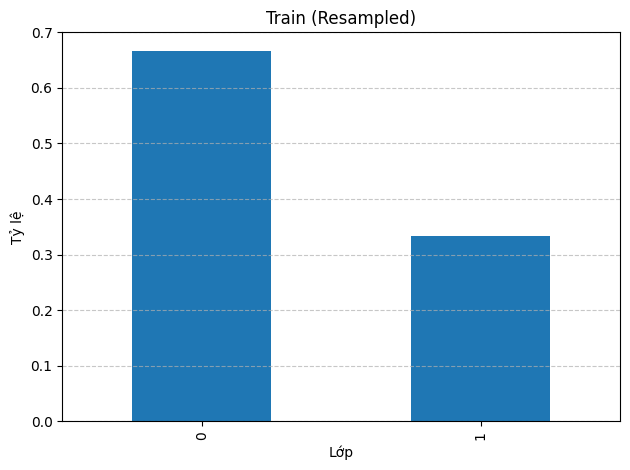

Tỷ lệ lớp - Validation:
fraud
0    0.987338
1    0.012662
Name: proportion, dtype: float64



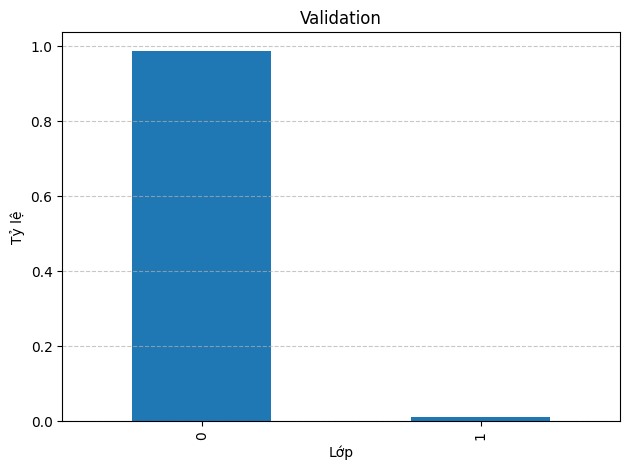

Tỷ lệ lớp - Test:
fraud
0    0.987338
1    0.012662
Name: proportion, dtype: float64



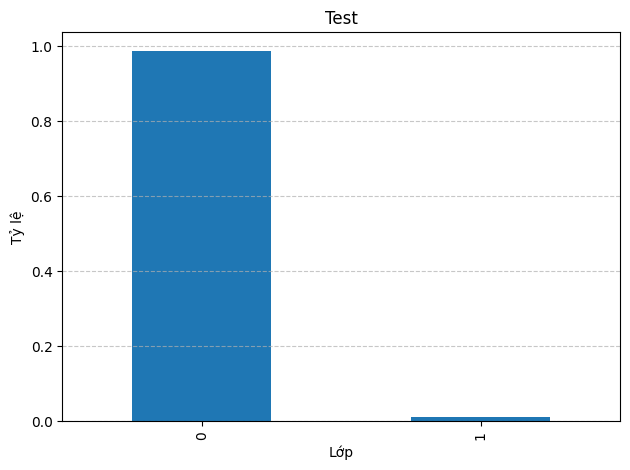

In [22]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Giả sử bạn đã chia X, y thành train, val, test từ trước
# Nếu chưa, bạn có thể làm như sau:
# X_train_full, X_temp, y_train_full, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Áp dụng oversampling và undersampling lên TRAIN SET
oversampler = SMOTE(sampling_strategy=0.2, random_state=42)
undersampler = RandomUnderSampler(sampling_strategy=0.5, random_state=42)

X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_resampled, y_train_resampled)

# Hàm in và vẽ tỷ lệ lớp
def show_class_distribution(y, title):
    dist = pd.Series(y).value_counts(normalize=True)
    print(f"Tỷ lệ lớp - {title}:\n{dist}\n")
    dist.plot(kind='bar', title=title)
    plt.xlabel('Lớp')
    plt.ylabel('Tỷ lệ')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# In và vẽ biểu đồ phân bố lớp
show_class_distribution(y_train_resampled, "Train (Resampled)")
show_class_distribution(y_val, "Validation")
show_class_distribution(y_test, "Test")


In [23]:
# Tính tỷ lệ lớp trong tập huấn luyện và tập kiểm tra
class_distribution = data['fraud'].value_counts(normalize=True)

print("Tỉ lệ các lớp trong tập data:")
print(class_distribution)



Tỉ lệ các lớp trong tập data:
fraud
0    0.987338
1    0.012662
Name: proportion, dtype: float64


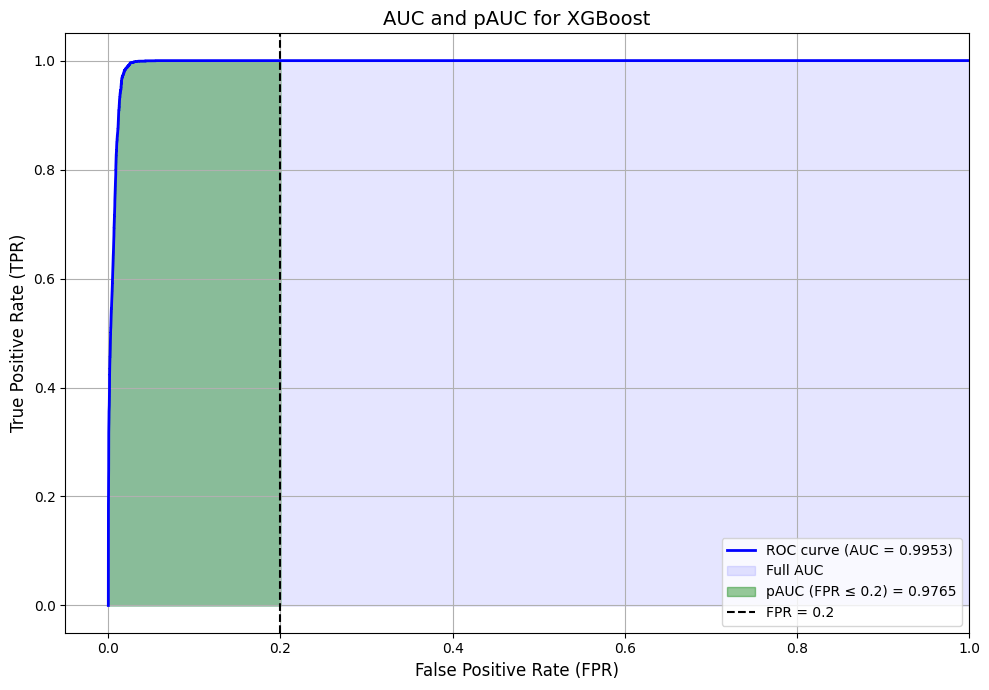

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Dữ liệu đầu vào (đã train model)
y_true = y  # true labels
y_scores = full_pipeline.predict_proba(X)[:, 1]  # xác suất nhãn 1 (fraud)

# Tính ROC curve và AUC
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Tính pAUC với FPR ≤ 0.2
max_fpr = 0.2
mask = fpr <= max_fpr
fpr_trunc = fpr[mask]
tpr_trunc = tpr[mask]

# Nội suy thêm điểm tại FPR = 0.2 nếu cần
if fpr_trunc[-1] < max_fpr and len(fpr_trunc) > 1:
    slope = (tpr_trunc[-1] - tpr_trunc[-2]) / (fpr_trunc[-1] - fpr_trunc[-2])
    tpr_at_02 = tpr_trunc[-1] + slope * (max_fpr - fpr_trunc[-1])
    fpr_trunc = np.append(fpr_trunc, max_fpr)
    tpr_trunc = np.append(tpr_trunc, tpr_at_02)

pauc = auc(fpr_trunc, tpr_trunc)
pauc_normalized = pauc / max_fpr

# Vẽ biểu đồ
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')

# Full AUC background
plt.fill_between(fpr, tpr, alpha=0.1, color='blue', label='Full AUC')

# pAUC highlight
plt.fill_between(fpr_trunc, tpr_trunc, alpha=0.4, color='green',
                 label=f'pAUC (FPR ≤ {max_fpr}) = {pauc_normalized:.4f}')

# FPR = 0.2 line
plt.axvline(x=max_fpr, color='black', linestyle='--', label=f'FPR = {max_fpr}')

# Trang trí
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('AUC and pAUC for XGBoost', fontsize=14)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.grid(True)
plt.legend(loc='lower right', fontsize=10)
plt.tight_layout()
plt.show()


preprocessing

[0]	validation_0-logloss:0.15885
[1]	validation_0-logloss:0.14796
[2]	validation_0-logloss:0.13812
[3]	validation_0-logloss:0.12927
[4]	validation_0-logloss:0.12138
[5]	validation_0-logloss:0.11415
[6]	validation_0-logloss:0.10715
[7]	validation_0-logloss:0.10097
[8]	validation_0-logloss:0.09579
[9]	validation_0-logloss:0.09091
[10]	validation_0-logloss:0.08616
[11]	validation_0-logloss:0.08166
[12]	validation_0-logloss:0.07748
[13]	validation_0-logloss:0.07352
[14]	validation_0-logloss:0.07019
[15]	validation_0-logloss:0.06722
[16]	validation_0-logloss:0.06453
[17]	validation_0-logloss:0.06189
[18]	validation_0-logloss:0.05966
[19]	validation_0-logloss:0.05743
[20]	validation_0-logloss:0.05535
[21]	validation_0-logloss:0.05354
[22]	validation_0-logloss:0.05190
[23]	validation_0-logloss:0.05019
[24]	validation_0-logloss:0.04848
[25]	validation_0-logloss:0.04713
[26]	validation_0-logloss:0.04586
[27]	validation_0-logloss:0.04470
[28]	validation_0-logloss:0.04353
[29]	validation_0-loglos

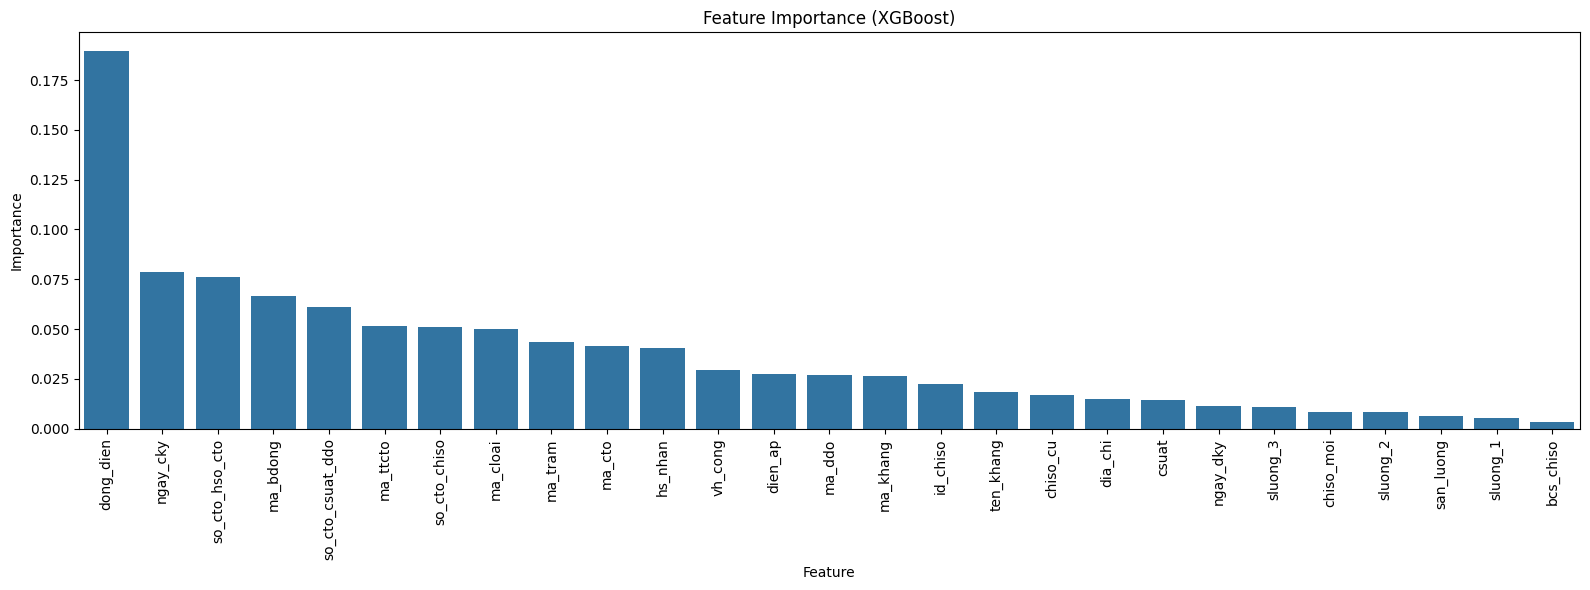

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier, callback
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Đọc dữ liệu
df_train = pd.read_parquet('trainn.parquet')
df_valid = pd.read_parquet('vali.parquet')
df_test  = pd.read_parquet('testt.parquet')

# 2. Cột loại bỏ
cols_to_drop = [
    'fraud', 'ngay_hhluc_khang', 'ngay_hhluc_vitri_ddo', 'ngay_hhluc_diemdo', 'ngay_hhluc',
    'id_bcs', 'ngay_kdinh', 'loai_chiso', 'ngay_hluc_diem_do', 'ngay_hluc_vitri_ddo',
    'thang_csuat_ddo', 'ngay_hluc_khang', 'gia_tri', 'loai_giatri', 'kimua_cspk',
    'id_ddo', 'ma_dviqly', 'so_cot', 'so_hop', 'ma_dvictren', 'ky', 'thang', 'nam',
    'sluong_ttiep', 'sluong_trphu', 'thd_le', 'ma_cnang_chiso', 'ngay_bdong',
    'id_khang', 'so_pha', 'ngay_tao_chiso', 'nguoi_tao_chiso', 'ngay_sua_chiso',
    'nguoi_sua_chiso', 'ngay_hluc'
]

# 3. Tách X, y
X_train = df_train.drop(columns=cols_to_drop)
y_train = df_train['fraud']
X_valid = df_valid.drop(columns=cols_to_drop)
y_valid = df_valid['fraud']
X_test = df_test.drop(columns=cols_to_drop)
y_test = df_test['fraud']

# 4. Mã hóa object
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train[cat_cols] = oe.fit_transform(X_train[cat_cols].astype(str))
X_valid[cat_cols] = oe.transform(X_valid[cat_cols].astype(str))
X_test[cat_cols]  = oe.transform(X_test[cat_cols].astype(str))

# 5. Cấu hình và huấn luyện XGBoost
SEED = 42
xgb_params = {
    'tree_method':        'hist',
    'random_state':       SEED,
    'learning_rate':      0.08501257473292347,
    'lambda':             8.879624125465703,
    'alpha':              0.6779926606782505,
    'max_depth':          6,
    'subsample':          0.6012681388711075,
    'colsample_bytree':   0.8437772277074493,
    'colsample_bylevel':  0.5476090898823716,
    'colsample_bynode':   0.9928601203635129,
    'scale_pos_weight':   3.29440313334688,
}

xgb_model = XGBClassifier(**xgb_params)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    
    verbose=True
)

# 6. Dự đoán
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
y_pred = xgb_model.predict(X_test)

# 7. Hàm custom partial AUC
def custom_metric(y_true, y_pred_proba):
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)
    v_gt = abs(y_true - 1)
    v_pred = 1.0 - np.array(y_pred_proba)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / 0.5 * (partial_auc_scaled - 0.5)
    return partial_auc

# 8. Đánh giá
print(f"AUC Score      : {roc_auc_score(y_test, y_pred_proba):.5f}")
print(f"Custom pAUC    : {custom_metric(y_test, y_pred_proba):.5f}")

# 9. Vẽ biểu đồ độ quan trọng
features = X_train.columns
tmp = pd.DataFrame({'Feature': features, 'Importance': xgb_model.feature_importances_})
tmp = tmp.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(16, 6))
sns.barplot(x='Feature', y='Importance', data=tmp)
plt.xticks(rotation=90)
plt.title('Feature Importance (XGBoost)')
plt.tight_layout()
plt.show()


In [2]:
import xgboost
print(xgboost.__version__)


3.0.2
